<a href="https://colab.research.google.com/github/dbarrau/TensorFlow_training/blob/main/food_101_on_efficient_netB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi -L
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4786f7b6-a3a8-2599-6fd0-7271d0fae2b6)
--2022-08-01 15:41:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-01 15:41:27 (32.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import itertools
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.metrics import confusion_matrix, classification_report
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, make_confusion_matrix


## Use TensorFlow Datasets to download data 


In [ ]:
# list all available datasets 
dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [ ]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True,
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteFWPLVF/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteFWPLVF/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from tensorFlow Datasets

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of train data
train_one_sample = train_data.take(1)

In [ ]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target clas from Food101 (tensor form): {label}
  class name (str form) {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target clas from Food101 (tensor form): 56
  class name (str form) huevos_rancheros
  


In [ ]:
# What does our image tensor look list
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Values are uint8, between 0 and 255. We need to preprocess our images, soon...

In [ ]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

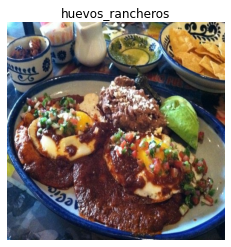

In [ ]:
plt.imshow(image);
plt.title(class_names[label.numpy()])
plt.axis(False);

This is how our images look like now

## Data preprocessing

We need:

Change the datatype to float
Change image size

In [ ]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' to 'float32' and reshapes image to 
  [img_shape, img_shape, color channels]
  """

  # Reshape target image
  image = tf.image.resize(image, [img_shape, img_shape])

  # Return float 32 (image, label) tuple
  return tf.cast(image, tf.float32), label

## Batch and prepare datasets 

In [ ]:
# Map preprocessing function to training data (and parellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train data and turn into batches and prefetch it (load faster)
train_data = train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks


In [ ]:
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      verbose=0)



## Set up mixed precision training 

In [ ]:
# Turn on mixed precision training 

mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Build Feature extraction model


In [ ]:
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable=False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

71696384/71686520 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 17,854,916
Trainable params: 181,093
Non-traina

## Checking layer dtype policies (are we using mixed precision)

In [ ]:
# Check out the dtype policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb4 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in model.layers[1].layers[:20]:
  print(layer.name, layer.dtype_policy)

input_1 <Policy "float32">
rescaling <Policy "mixed_float16">
normalization <Policy "mixed_float16">
stem_conv_pad <Policy "mixed_float16">
stem_conv <Policy "mixed_float16">
stem_bn <Policy "mixed_float16">
stem_activation <Policy "mixed_float16">
block1a_dwconv <Policy "mixed_float16">
block1a_bn <Policy "mixed_float16">
block1a_activation <Policy "mixed_float16">
block1a_se_squeeze <Policy "mixed_float16">
block1a_se_reshape <Policy "mixed_float16">
block1a_se_reduce <Policy "mixed_float16">
block1a_se_expand <Policy "mixed_float16">
block1a_se_excite <Policy "mixed_float16">
block1a_project_conv <Policy "mixed_float16">
block1a_project_bn <Policy "mixed_float16">
block1b_dwconv <Policy "mixed_float16">
block1b_bn <Policy "mixed_float16">
block1b_activation <Policy "mixed_float16">


In [ ]:
starting_epochs = 3
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=starting_epochs,
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[model_checkpoint,
                               create_tensorboard_callback(dir_name="food_vision",
                                                          experiment_name="feature_extractor")])

Saving TensorBoard log files to: food_vision/feature_extractor/20220801-154815
Epoch 1/3
2368/2368 [==============================] - 231s 88ms/step - loss: 1.8694 - accuracy: 0.5377 - val_loss: 1.3352 - val_accuracy: 0.6520
Epoch 2/3
2368/2368 [==============================] - 205s 87ms/step - loss: 1.3896 - accuracy: 0.6388 - val_loss: 1.2427 - val_accuracy: 0.6748
Epoch 3/3
2368/2368 [==============================] - 206s 87ms/step - loss: 1.2406 - accuracy: 0.6756 - val_loss: 1.2061 - val_accuracy: 0.6822


In [ ]:
results_feature_extractor = model.evaluate(test_data)

790/790 [==============================] - 66s 84ms/step - loss: 1.1965 - accuracy: 0.6796


In [ ]:
model.save("drive/MyDrive/tensorflow-stuff/EfficientNetB4_feature_extractor")

INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow-stuff/EfficientNetB4_feature_extractor/assets


INFO:tensorflow:Assets written to: drive/MyDrive/tensorflow-stuff/EfficientNetB4_feature_extractor/assets


## Prepare our model's layers for fine tuning

In [ ]:
# Set all layers as trainble (unfreeze the layers)
model.trainable = True

## Setup callbacks for fine tuning 

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,
                                                  monitor="val_loss")

# Setup model checkpoints 
checkpoint_path = "fine_tuned_model_checkpoints/cp.cptk"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      verbose=0,
                                                      monitor="val_loss",
                                                      save_best_only=True)

# Setup variable learning rate
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 min_lr=1e-7)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=["accuracy"])

In [ ]:
history_fine_tuned = model.fit(train_data,
                                 epochs=100,
                                 steps_per_epoch=len(train_data),
                                 validation_data=test_data,
                                 validation_steps=int(0.15*len(test_data)),
                                 callbacks=[model_checkpoint,
                                            early_stopping,
                                            reduce_lr,
                                            create_tensorboard_callback("food_vision",
                                                                        "EfficientNetB4_all_layers_fine_tuned")])

Saving TensorBoard log files to: food_vision/EfficientNetB4_all_layers_fine_tuned/20220801-160217
Epoch 1/100
2368/2368 [==============================] - 946s 387ms/step - loss: 0.9264 - accuracy: 0.7501 - val_loss: 0.7064 - val_accuracy: 0.8083 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 912s 385ms/step - loss: 0.3540 - accuracy: 0.9038 - val_loss: 0.8612 - val_accuracy: 0.7730 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 912s 385ms/step - loss: 0.1354 - accuracy: 0.9593 - val_loss: 1.0281 - val_accuracy: 0.7730 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 912s 385ms/step - loss: 0.0337 - accuracy: 0.9903 - val_loss: 0.9458 - val_accuracy: 0.8175 - lr: 2.0000e-05


In [ ]:
fined_tuned_model_results = model.evaluate(test_data)

790/790 [==============================] - 65s 82ms/step - loss: 0.9408 - accuracy: 0.8213


In [ ]:
pred_probs = model.predict(test_data)

In [ ]:
y_pred = pred_probs.argmax(axis=1)

In [ ]:
y_true = []

for images, labels in test_data.unbatch():
  y_true.append(labels.numpy())

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import itertools

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(100, 100), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ## Changed (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

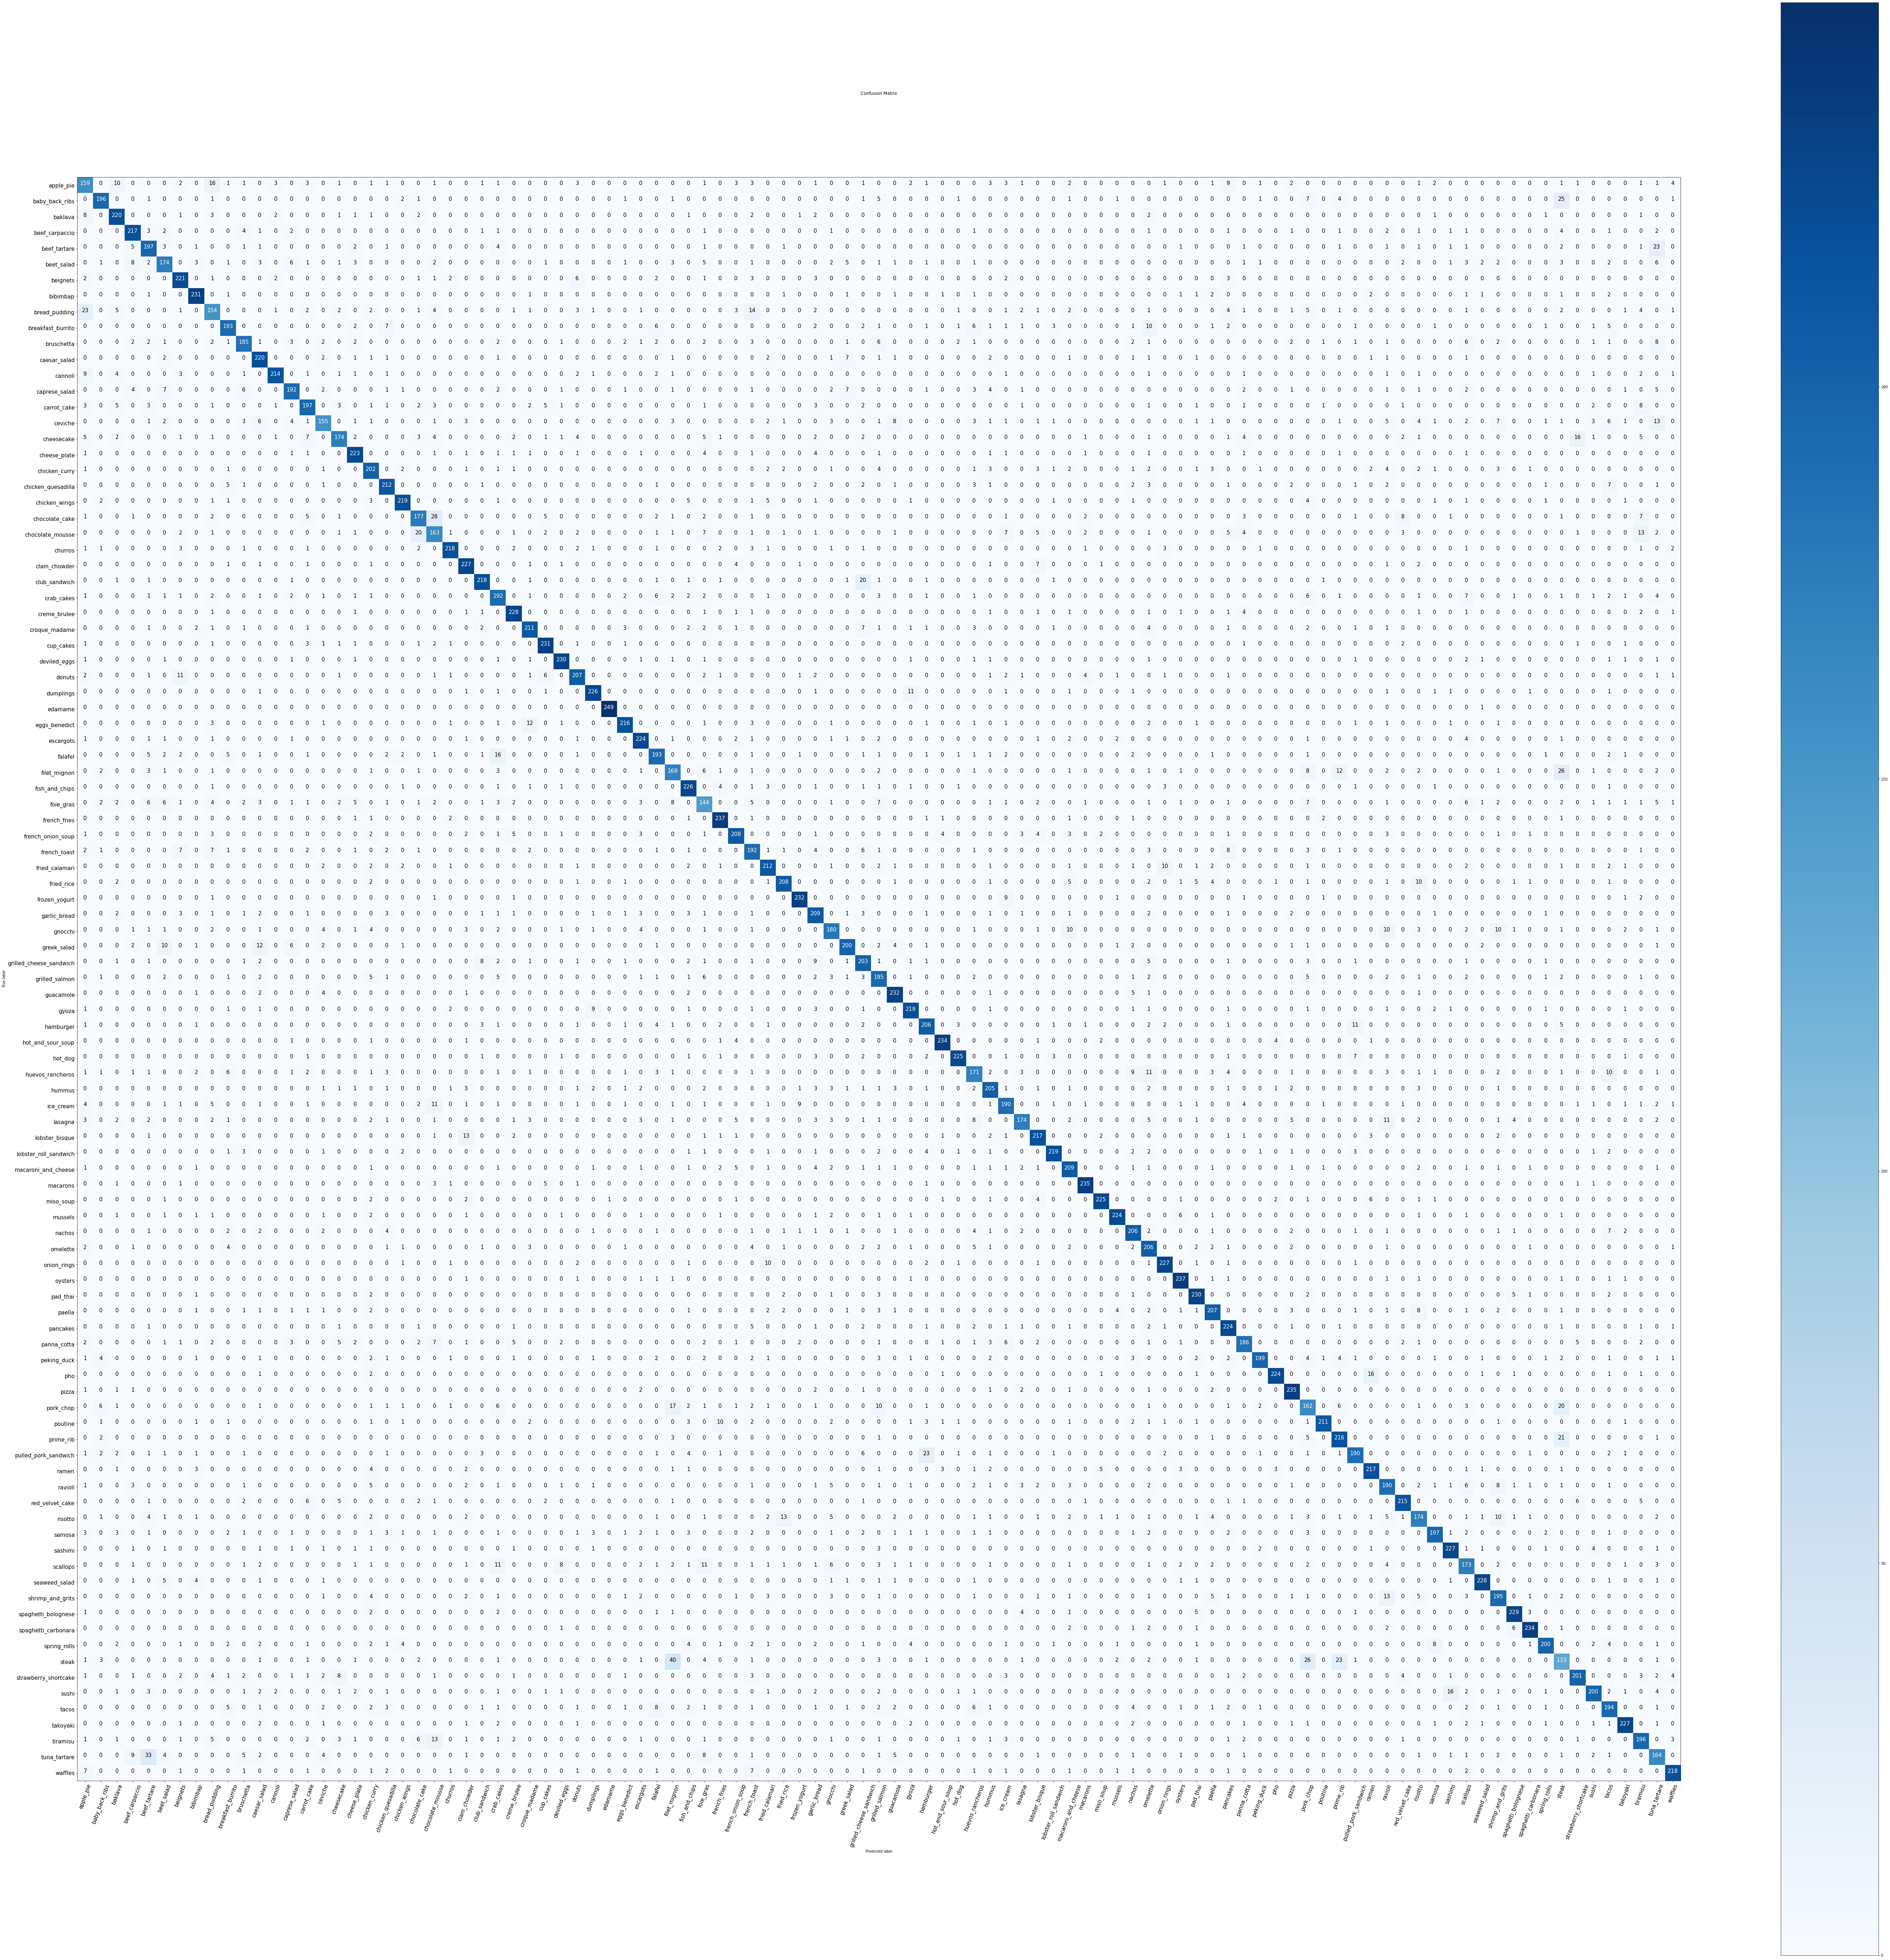

In [ ]:
make_confusion_matrix(y_true,y_pred, classes=class_names)

In [ ]:
classification_report_dict = classification_report(y_true, y_pred, output_dict=True, target_names=class_names)
print(classification_report(y_true, y_pred, target_names=class_names))

                         precision    recall  f1-score   support

              apple_pie       0.62      0.64      0.63       250
         baby_back_ribs       0.87      0.78      0.82       250
                baklava       0.81      0.88      0.85       250
         beef_carpaccio       0.84      0.87      0.85       250
           beef_tartare       0.70      0.79      0.74       250
             beet_salad       0.75      0.70      0.72       250
               beignets       0.82      0.88      0.85       250
               bibimbap       0.90      0.92      0.91       250
          bread_pudding       0.67      0.62      0.64       250
      breakfast_burrito       0.81      0.77      0.79       250
             bruschetta       0.81      0.74      0.78       250
           caesar_salad       0.78      0.88      0.83       250
                cannoli       0.95      0.86      0.90       250
          caprese_salad       0.84      0.77      0.80       250
            carrot_cake 

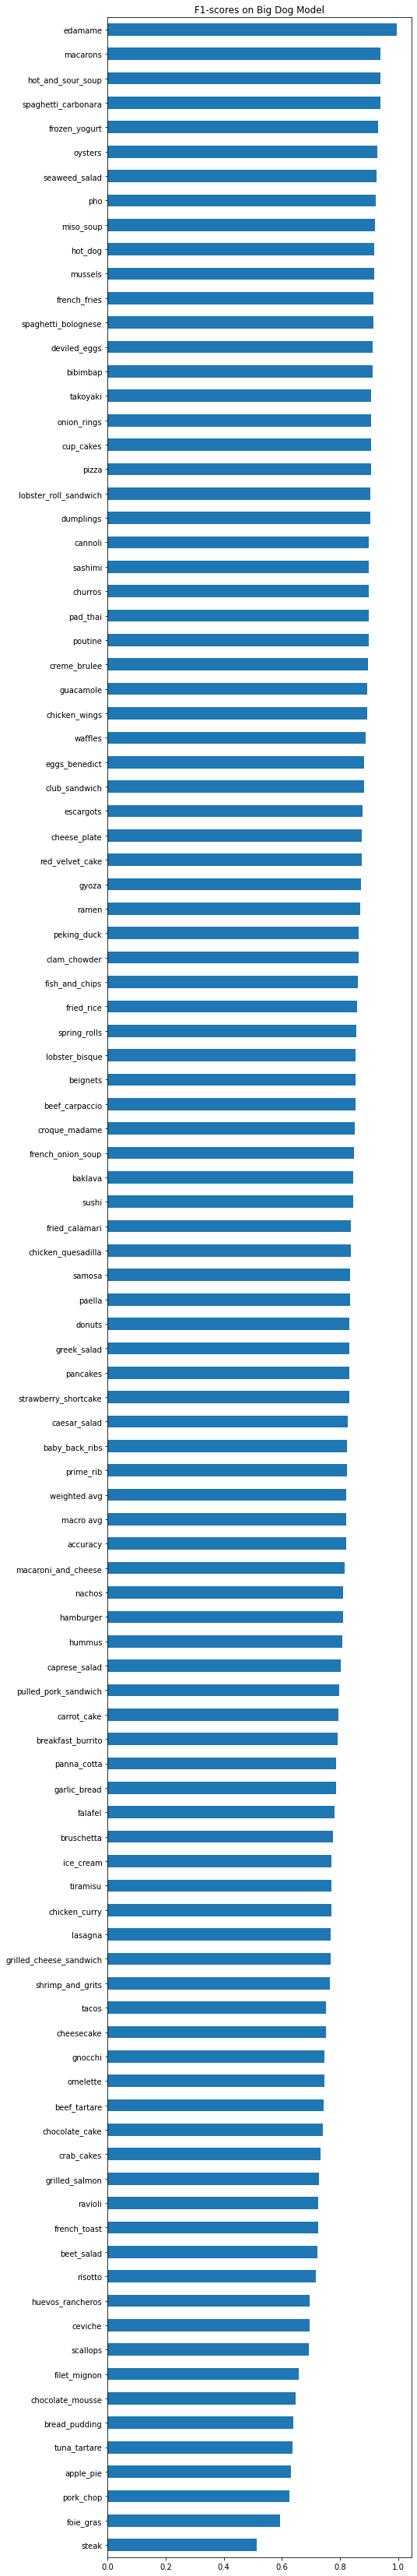

In [ ]:
import pandas as pd
df_score_report = pd.DataFrame(classification_report_dict)
df_score_report = df_score_report.transpose()

df_score_report["f1-score"].sort_values().plot(kind="barh", 
                                               figsize=(7,60),
                                               title="F1-scores on Big Dog Model");